# Review and Monitor Item Cancellations

This notebook monitors item cancellations over time. A cancelled item is an item that stopped selling and then it was never reintroduced.

1. Count of introduced cencelled per year and per month.
2. Count of introduced cancelled per year and per month per department.

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ks_2samp
import ruptures as rpt
import sys
import os

# --- Imports from project root ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",".."))
sys.path.append(project_root)
from src.core.clients.bigquery import BigQueryClient

# --- Plotting style ---
sns.set(style='whitegrid', context='notebook')

In [5]:
# --- Load Data From BigQuery ---
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()


item_longevity_query = """
    SELECT 
        *
    FROM `porygon-pipelines.walmart_targets_and_filters.feature_items_not_continued`
"""

# Extract data
item_long = bq_client.load_from_query(item_longevity_query)

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


INFO:src.core.clients.bigquery:Loaded 195136 rows from custom query.


In [7]:
# --- Prepare Data ---

# initialize a table of initialized items.
df_introductions = item_long[item_long["fea_month_cancelled"]==0]

# Create column to denote year.
df_introductions["year"] = pd.DatetimeIndex(df_introductions['ctx_date_month']).year

# Extract deparment ID from item ID.
def extract_deptarmtner_id(s):
    return f"{s.split("_")[0]}_{s.split("_")[1]}"
df_introductions["ctx_dept_id"] = df_introductions["ctx_item_id"].apply(lambda x: extract_deptarmtner_id(x))


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_4269/2813645169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_introductions["year"] = pd.DatetimeIndex(df_introductions['ctx_date_month']).year
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_4269/2813645169.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_introductions["ctx_dept_id"] = df_introductions["ctx_item_id"].apply(lambda x: extract_deptarmtner_id(x))


# 0.1 Count of cancelled items per year.

In [14]:
# Group by year and department, count months per group
grouped = (
    df_introductions
    .groupby(["year"])
    .agg(month_count=("ctx_date_month", "count"))
    .reset_index()
)


grouped

,year,month_count
0,2014,1
1,2015,35
2,2016,3013


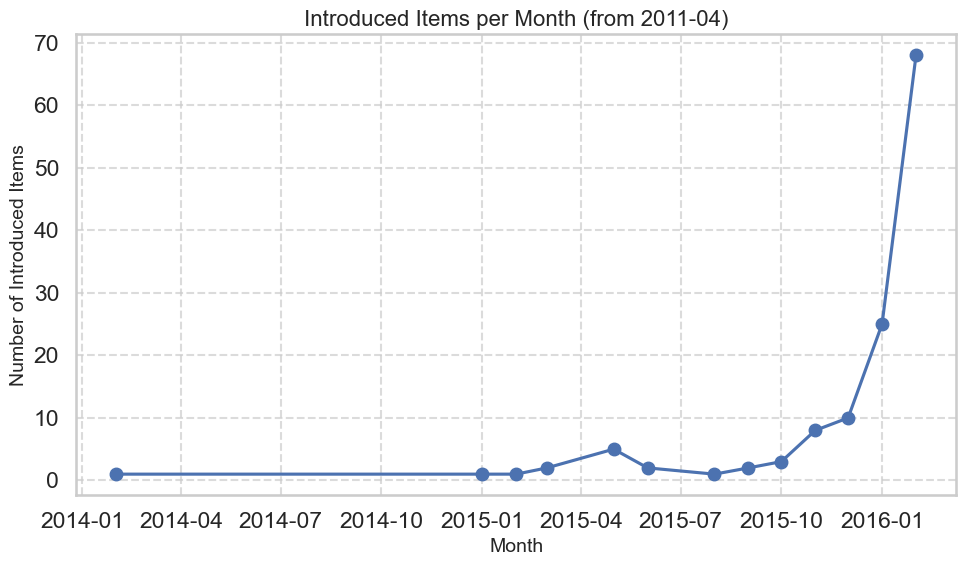

In [13]:
# Group by year and department, count months per group
grouped = (
    df_introductions
    .groupby(["ctx_date_month"])
    .agg(month_count=("ctx_date_month", "count"))
)

# Filter data
filtered = grouped[grouped.index < pd.to_datetime('2016-03-01')]

# Set plot style
sns.set(style="whitegrid", context="talk")

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot

filtered.plot(ax=ax, legend=False , color='b', marker='o')

# Beautify
ax.set_title("Introduced Items per Month (from 2011-04)", fontsize=16)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Number of Introduced Items", fontsize=14)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# 0.2 Count of introduced items per year per department.

In [15]:
# Group by year and department, count months per group
df_introductions_filtered = df_introductions[df_introductions["ctx_date_month"] > pd.to_datetime('2011-01-01')]
grouped = (
    df_introductions_filtered
    .groupby(["year", "ctx_dept_id"])
    .agg(month_count=("ctx_date_month", "count"))
    .reset_index()
)

# Pivot to get years as rows and departments as columns
dept_row_count_per_year = grouped.pivot(
    index="year",
    columns="ctx_dept_id",
    values="month_count"
)


dept_row_count_per_year

ctx_dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
year,,,,,,,
2014,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2015,1.0,NaN,11.0,4.0,3.0,5.0,11.0
2016,215.0,398.0,812.0,411.0,146.0,527.0,504.0


In [16]:
def plot_new_introductions_over_time_per_dept(dept_id, df_introductions, dept_row_count_per_year):
    import matplotlib.dates as mdates

    # Filter data for the specified department
    df = df_introductions[df_introductions["ctx_dept_id"] == dept_id]
    # Group by month, count introductions
    grouped = (
        df
        .groupby(["ctx_date_month"])
        .agg(month_count=("ctx_date_month", "count"))
    )
    filtered = grouped[grouped.index >= pd.to_datetime('2011-04-01')]

    # Calculate 90th percentile
    perc_95 = filtered["month_count"].quantile(0.95)
    perc_05 = filtered["month_count"].quantile(0.05)

    # Prepare yearly data for the right axis
    yearly = dept_row_count_per_year[dept_id].dropna()
    # Convert years to datetime for plotting
    years_as_datetime = pd.to_datetime(yearly.index.astype(str) + "-07-01")  # middle of year

    # Set plot style
    sns.set(style="whitegrid", context="talk")

    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Left axis: monthly introductions
    filtered.plot(ax=ax1, legend=False, color='b', marker='o')
    ax1.set_ylabel("Number of Introduced Items (Monthly)", fontsize=14, color='b')
    ax1.set_xlabel("Month", fontsize=14)
    ax1.tick_params(axis='y', labelcolor='b')

    # Add 90th percentile line
    ax1.axhline(perc_95, color='red', linestyle='--', linewidth=2, label='95th Percentile')
    ax1.axhline(perc_05, color='red', linestyle='--', linewidth=2, label='05th Percentile')

    # Right axis: yearly summary
    ax2 = ax1.twinx()
    ax2.plot(years_as_datetime, yearly.values, color='orange', marker='s', linestyle='-', label='Yearly Total')
    ax2.set_ylabel("Number of Introduced Items (Yearly)", fontsize=14, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Beautify
    ax1.set_title(f"Introduced Items per Month and Year - {dept_id}", fontsize=16)
    ax1.grid(True, which='major', linestyle='--', alpha=0.7)
    fig.tight_layout()

    # Gather handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2

    # Place a single combined legend
    ax1.legend(handles, labels)

    plt.show()


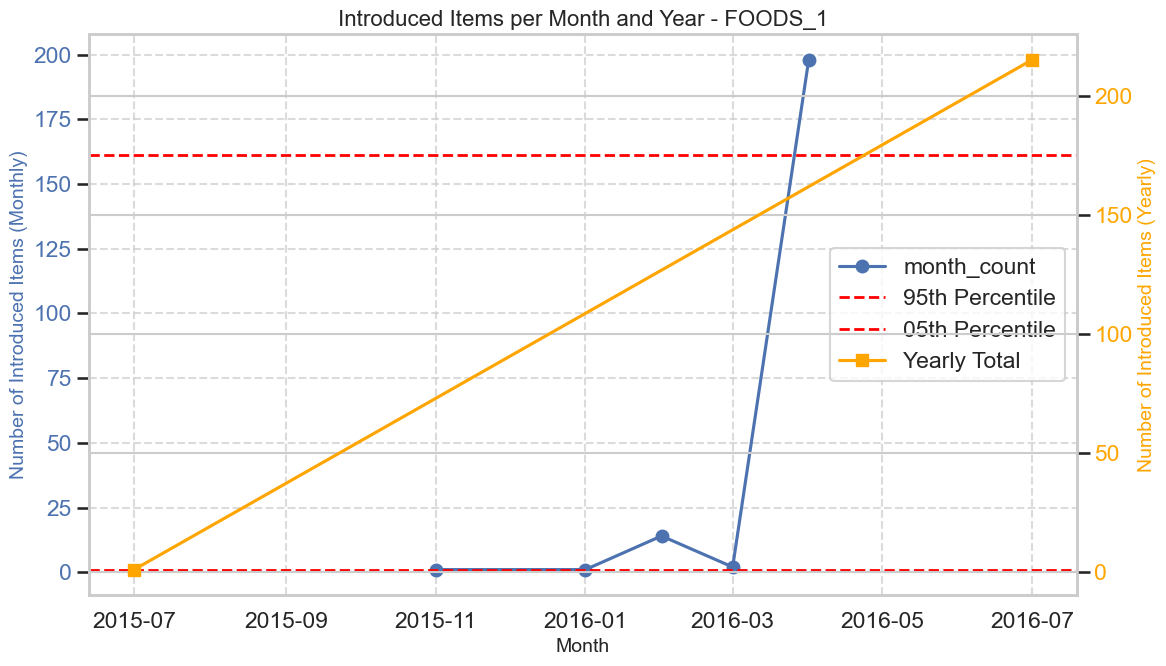

In [17]:
plot_new_introductions_over_time_per_dept("FOODS_1", df_introductions, dept_row_count_per_year)

##### Observations: 
1. No new introductions in 2015. 
2. Spike of introductions at the beginning of 2012 and 2013.

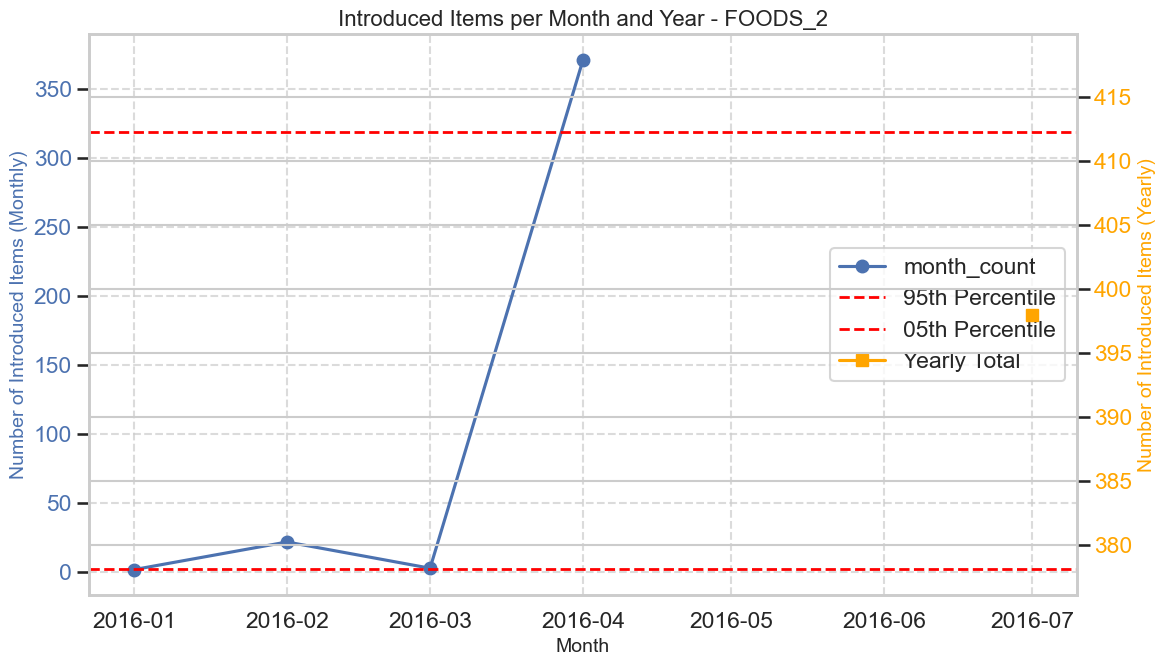

In [18]:
plot_new_introductions_over_time_per_dept("FOODS_2", df_introductions, dept_row_count_per_year)


##### Observations: 
1. Decline of new introductions in 2015. 
2. Was relatively consistent in introductions throughout.

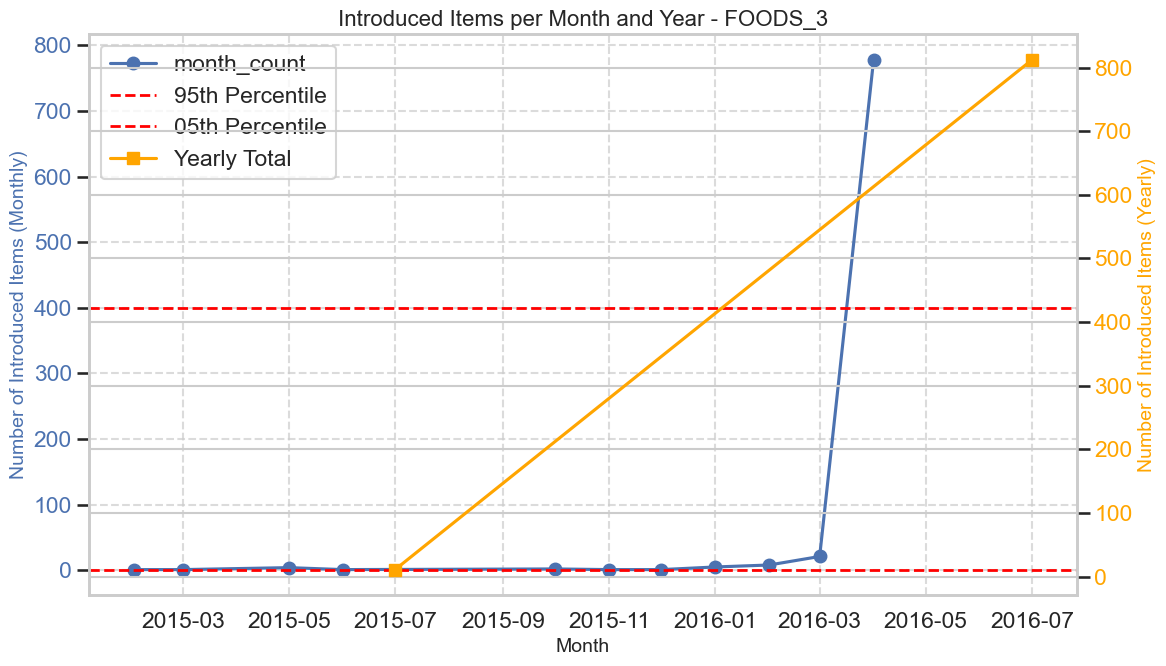

In [19]:
plot_new_introductions_over_time_per_dept("FOODS_3", df_introductions, dept_row_count_per_year)

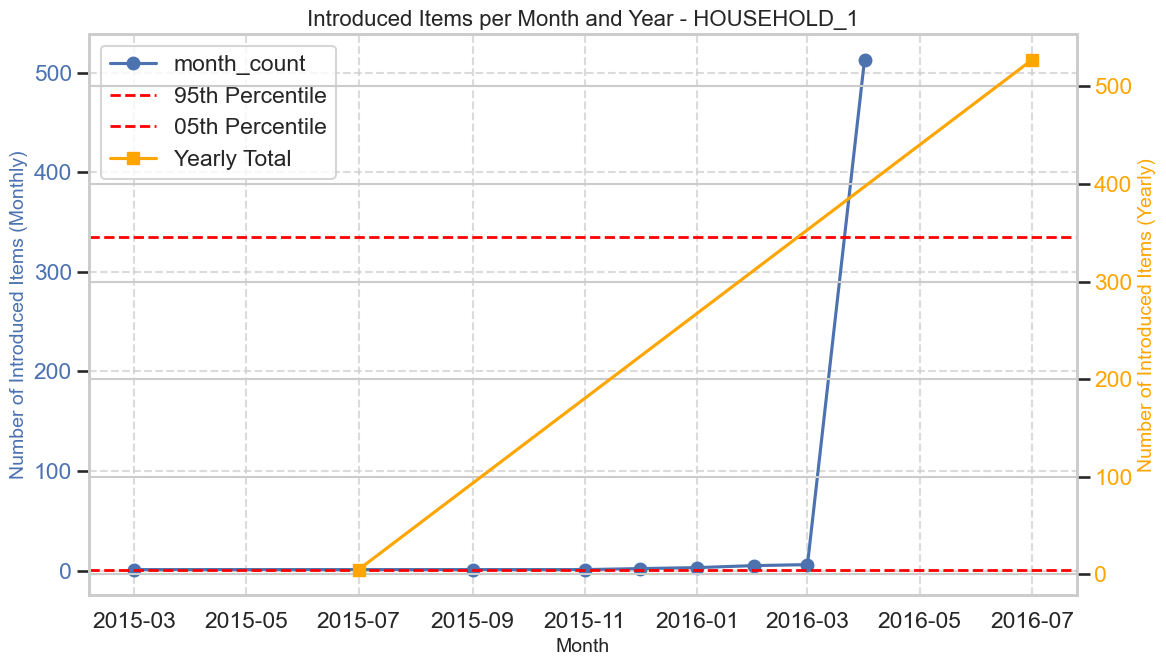

In [20]:
plot_new_introductions_over_time_per_dept("HOUSEHOLD_1", df_introductions, dept_row_count_per_year)

New introductions are almost seasonal with a decline on new introductions since 2014 onward.

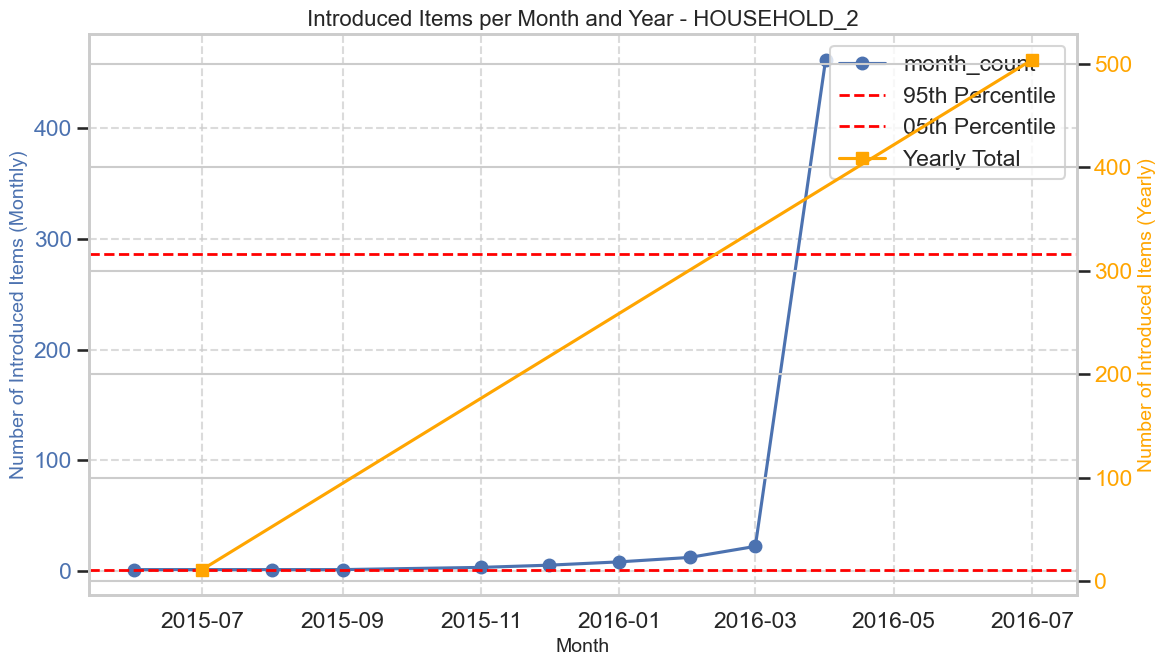

In [21]:
plot_new_introductions_over_time_per_dept("HOUSEHOLD_2", df_introductions, dept_row_count_per_year)

Same as before. New introductions declined by the end of 2014. Note taht in the case of households 2 there is a change point around 2014. The same time where the new introductions start to decline.

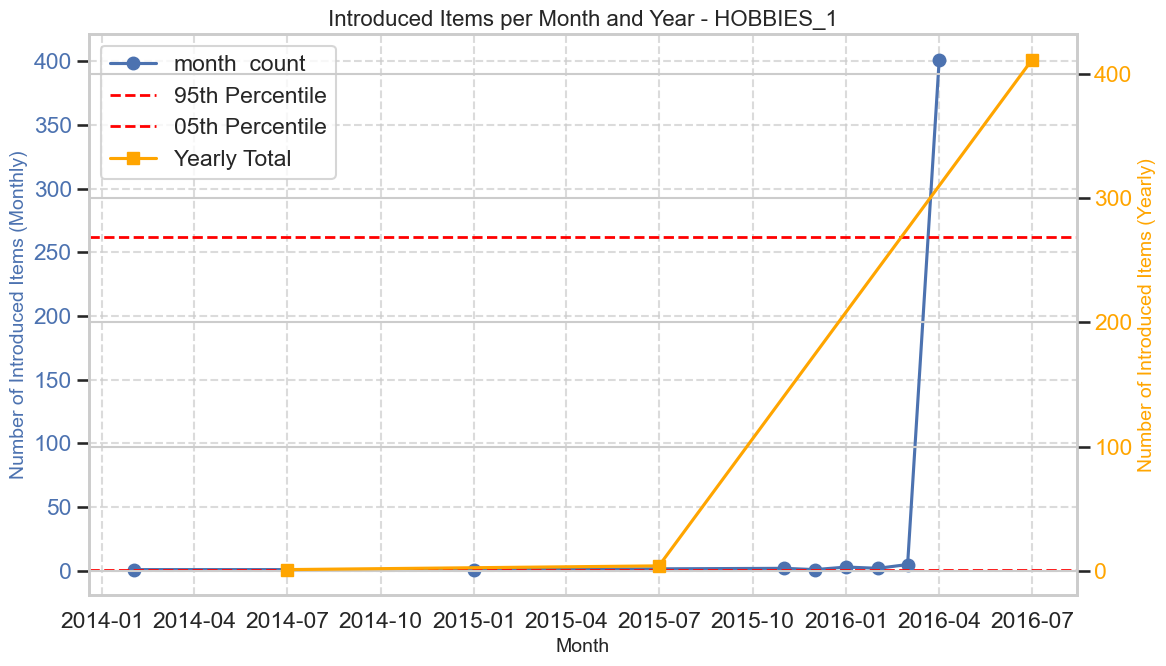

In [22]:
plot_new_introductions_over_time_per_dept("HOBBIES_1", df_introductions, dept_row_count_per_year)

Hobbies 1 has had a steady decline in new items introduced over time.

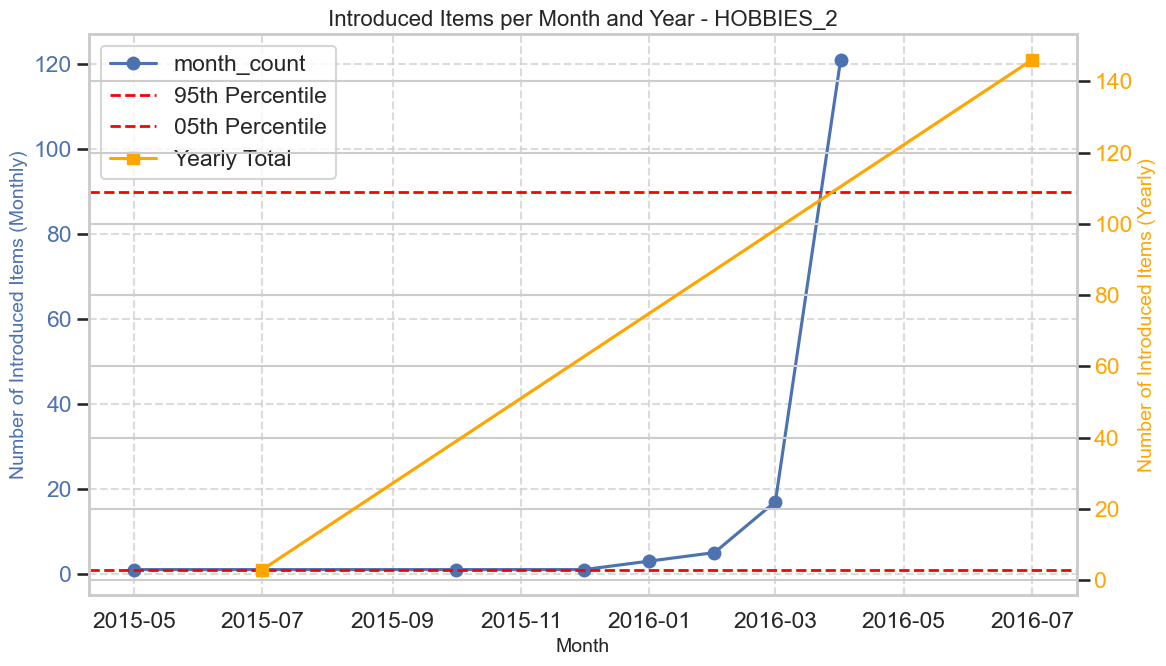

In [23]:
plot_new_introductions_over_time_per_dept("HOBBIES_2", df_introductions, dept_row_count_per_year)

# Observations:

There are no records of items being discontinued.